### Import das bibliotecas

In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
from scipy.special import expit
from scipy.stats import zscore
from pandas.errors import SettingWithCopyWarning
import os
from os import listdir
from os import system
import subprocess

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=SettingWithCopyWarning)


sns.set_theme(rc={'figure.figsize':(11.7,8.27)})

### Métodos auxiliares

In [2]:
def getSigmoid():
    arr = np.arange(0, 1, 0.02)
    np.hstack(np.vstack(arr))
    def sigmoid(x):
        return 1/(1+expit(-x))
    
    sigmoid(arr)
    sns.scatterplot(x=arr, y=sigmoid(arr))

def get_files(n=1, lazy=True):
    
    cwd = os.getcwd()
    
    list_files = [x for x in listdir(cwd + "/data/estacoes_solares/2023") if ".CSV" in x]
    dict_data = {}

    if n:
        _range = list_files[0:n]
    else:
        _range = list_files
    
    for i in _range:
        # print("Processando arquivo " + i)
        
        code = i.split("_")[3]
        
        cmd = ["head", "-8", cwd+"/data/estacoes_solares/2023/"+i]
        p = subprocess.Popen(cmd, stdout=subprocess.PIPE)
        
        result = p.communicate()
        head = result[0].decode('ISO-8859-1')
    
        if lazy:
            data = "data/estacoes_solares/2023/"+i
        else:
            data = pd.read_csv("data/estacoes_solares/2023/"+i, sep=";", encoding = "ISO-8859-1", skiprows=8)
        
        dict_data[code] = [head, data]

    return dict_data

def getDictToRenameDataFrame(list_columns):
    list_columns_new = []
    for i in list_columns: 
        list_columns_new.append(str
              .lower(i)
              .replace(" ", "_")
              . replace("(", "_")
              .replace(")", "")
              .replace("/", "")
              .replace("²", "2")
              .replace("°", "")
              .replace("%", "perc")
              .replace("._", "_")
              .replace(".", "_")
              .replace("__", "_")
              .replace("_-_", "_")
              .replace(",_", "_")
             )
    
    return dict(zip(list_columns, list_columns_new))

def renameDatasetColumns(df):
    list_columns = df.columns

    list_dict_to_rename = getDictToRenameDataFrame(list_columns)
    return df.rename(columns=list_dict_to_rename).drop(["unnamed:_19"], axis=1)

def hour_transform(n):
    if len(str(n)) == 4:
        return str(n)[0:2] + ":" + str(n)[2:] + ":00"
    elif len(str(n)) == 3:
        return "0" + str(n)[0:1] + ":" + str(n)[1:] + ":00"
    elif n == 0:
        return "00:00:00"

def transform_datetime(df):
    df["data_medicao"] = df["data"].str.replace('/', '-', regex=False)
    df["hora_medicao"] = df["hora_utc"].str.replace(' UTC', '', regex=False).astype('int32')
    return df.drop(["data", "hora_utc"], axis=1)
    # 2023/05/18 	2300 UTC

def create_datetime_feature(df):
    df["hora_medicao"] = df["hora_medicao"].apply(hour_transform)
    df["data_hora_str"] = df["data_medicao"] + " " + df["hora_medicao"]
    df["data_hora"] = pd.to_datetime(df["data_hora_str"])
    df["hora"] = df['data_hora'].dt.hour
    
    return df.drop(["data_hora_str", "data_medicao", "hora_medicao"], axis=1)

def create_split_date_features(df):
    df["dia"] = df["data_hora"].dt.day
    df["mes"] = df["data_hora"].dt.month
    df["ano"] = df["data_hora"].dt.year

    return df

def create_category(column, df):
    labels = ["A", "B", "C", "D"]
    classes = df.describe()[column][3:8].values

    if classes[1] == 0:
        classes[1] = classes[1]+0.1
    
    return pd.cut(x = df[column],
         bins = classes,
         labels = labels,
         include_lowest = True)

def removeNulls(df, col):
    return df[df[col].notnull()]

def pre_processing(df):
    renameDatasetColumns(df)

def load(path):
    return pd.read_csv(path, sep=";", encoding = "ISO-8859-1", skiprows=8)

def get_perc_nulls(df):
    return (df.isnull().sum()/(len(df)))*100

def change_types(df):
    list_columns = ["precipitação_total_horário_mm",
                   "pressao_atmosferica_ao_nivel_da_estacao_horaria_mb",
                   "pressão_atmosferica_max_na_hora_ant_aut_mb",
                   "pressão_atmosferica_min_na_hora_ant_aut_mb",
                   "radiacao_global_kjm2",
                   "temperatura_do_ar_bulbo_seco_horaria_c",
                   "temperatura_do_ponto_de_orvalho_c",
                   "temperatura_máxima_na_hora_ant_aut_c",
                   "temperatura_mínima_na_hora_ant_aut_c",
                   "temperatura_orvalho_max_na_hora_ant_aut_c",
                   "temperatura_orvalho_min_na_hora_ant_aut_c",
                   "vento_rajada_maxima_ms",
                   "vento_velocidade_horaria_ms"]

    for i in list_columns:
        df[i] = df[i].str.replace(",", ".").astype('float64')
        
    return df

### Obtendo os dados
Por uma qestão de recursos, não foi possivel carregar todas as estações em um dicionário, por exemplo. Sendo assim, o método `get_files` tem um parâmetro que determina a condição de "lazy", ou seja, eu carrego somente os paths dos arquivos e vou carregando na memória somente o que usarei. Além disso, podemos especificar a quantidade de arquivos através do parâmetro `n`. 

In [3]:
dict_data = get_files(n=None)

In [4]:
print(dict_data.keys())

dict_keys(['A915', 'A528', 'A249', 'A899', 'A530', 'A624', 'A569', 'A017', 'A404', 'A897', 'A568', 'A011', 'A712', 'A916', 'A667', 'A325', 'A040', 'A217', 'A039', 'A251', 'A205', 'A552', 'A882', 'A303', 'A826', 'A806', 'A542', 'A874', 'A101', 'A228', 'A409', 'A342', 'A905', 'A895', 'A402', 'A758', 'A842', 'A828', 'A358', 'A545', 'A770', 'A253', 'A367', 'A450', 'A320', 'A214', 'A567', 'A837', 'A562', 'A312', 'A628', 'A609', 'A346', 'A527', 'A901', 'A349', 'A876', 'A441', 'A630', 'A375', 'A510', 'A536', 'A418', 'A360', 'A707', 'A743', 'A104', 'A871', 'A445', 'A742', 'A851', 'A513', 'A721', 'A333', 'A718', 'A364', 'A547', 'A439', 'A326', 'A315', 'A225', 'A055', 'A529', 'A659', 'A112', 'A345', 'A458', 'A352', 'A535', 'A022', 'A416', 'A340', 'A937', 'A855', 'A451', 'A344', 'A936', 'A823', 'A734', 'A544', 'A430', 'A811', 'A232', 'A764', 'A911', 'A329', 'A906', 'A509', 'A309', 'A009', 'A419', 'A248', 'A816', 'A448', 'A556', 'A252', 'A371', 'A516', 'A926', 'A363', 'A233', 'A879', 'A820', 'A749

### Renomeando as colunas

In [5]:
df = renameDatasetColumns(load(dict_data["A734"][1]))

### Showing info data

In [6]:
print(dict_data["A734"][0])

REGIAO:;SE
UF:;SP
ESTACAO:;VALPARAISO
CODIGO (WMO):;A734
LATITUDE:;-21,31916666
LONGITUDE:;-50,93027777
ALTITUDE:;381,9
DATA DE FUNDACAO:;30/08/07



In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 19 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   data                                                8760 non-null   object 
 1   hora_utc                                            8760 non-null   object 
 2   precipitação_total_horário_mm                       7608 non-null   object 
 3   pressao_atmosferica_ao_nivel_da_estacao_horaria_mb  8574 non-null   object 
 4   pressão_atmosferica_max_na_hora_ant_aut_mb          8571 non-null   object 
 5   pressão_atmosferica_min_na_hora_ant_aut_mb          8571 non-null   object 
 6   radiacao_global_kjm2                                4633 non-null   object 
 7   temperatura_do_ar_bulbo_seco_horaria_c              8574 non-null   object 
 8   temperatura_do_ponto_de_orvalho_c                   8574 non-null   object 
 9

O dataset contém uma quantidade consderável de nulos. Neste caso, vamos remover os nulos com base na característica teórica mais importante, a radiação. Mas antes, vamos só ver a porecntagem de nulos por coluna. E também, iremos precisar converter algumas colunas para float.

In [8]:
df = change_types(df)

In [9]:
get_perc_nulls(df)

data                                                   0.000000
hora_utc                                               0.000000
precipitação_total_horário_mm                         13.150685
pressao_atmosferica_ao_nivel_da_estacao_horaria_mb     2.123288
pressão_atmosferica_max_na_hora_ant_aut_mb             2.157534
pressão_atmosferica_min_na_hora_ant_aut_mb             2.157534
radiacao_global_kjm2                                  47.111872
temperatura_do_ar_bulbo_seco_horaria_c                 2.123288
temperatura_do_ponto_de_orvalho_c                      2.123288
temperatura_máxima_na_hora_ant_aut_c                   2.157534
temperatura_mínima_na_hora_ant_aut_c                   2.157534
temperatura_orvalho_max_na_hora_ant_aut_c              2.157534
temperatura_orvalho_min_na_hora_ant_aut_c              2.157534
umidade_rel_max_na_hora_ant_aut_perc                   2.157534
umidade_rel_min_na_hora_ant_aut_perc                   2.157534
umidade_relativa_do_ar_horaria_perc     

In [10]:
df_non_null = removeNulls(df, "radiacao_global_kjm2")

### Configurando campos de data e hora.
Como a coluna `data_medicao` e `hora_medicao` estão separadas e não são do tipo date/time, precisamos criar uma coluna que seja desse tipo. 

In [11]:
df_non_null_trans = transform_datetime(df_non_null)
df_non_null_dt = create_datetime_feature(df_non_null_trans)
df_non_null_dt = create_split_date_features(df_non_null_dt)

### Plot inicial dos dados

In [12]:
df_non_null_dt.head().T

,9,10,11,12,13
precipitação_total_horário_mm,NaN,NaN,NaN,NaN,NaN
pressao_atmosferica_ao_nivel_da_estacao_horaria_mb,969.3,969.7,970.1,970.9,970.8
pressão_atmosferica_max_na_hora_ant_aut_mb,969.3,969.8,970.1,970.9,970.9
pressão_atmosferica_min_na_hora_ant_aut_mb,968.5,969.3,969.7,970.1,970.7
radiacao_global_kjm2,5.1,315.2,1134.2,1971.6,2709.4
temperatura_do_ar_bulbo_seco_horaria_c,22.0,23.7,26.1,28.0,29.6
temperatura_do_ponto_de_orvalho_c,20.8,21.4,21.4,21.4,20.8
temperatura_máxima_na_hora_ant_aut_c,22.1,23.7,26.2,28.0,29.8
temperatura_mínima_na_hora_ant_aut_c,21.8,22.0,23.7,26.1,27.8
temperatura_orvalho_max_na_hora_ant_aut_c,20.9,21.5,22.3,21.6,21.4


In [13]:
df = df_non_null_dt

### Algumas estatísticas e Outliers
Uma checagem rápida das estatísticas dos dados para detectar em um rimeiro momento a presença de outliers. 

In [14]:
df_non_null_dt.describe().T

,count,mean,min,25%,50%,75%,max,std
precipitação_total_horário_mm,4111.0,0.285381,0.0,0.0,0.0,0.0,50.8,2.107343
pressao_atmosferica_ao_nivel_da_estacao_horaria_mb,4633.0,969.761558,959.4,967.1,969.7,972.3,981.2,3.785642
pressão_atmosferica_max_na_hora_ant_aut_mb,4630.0,970.127084,959.8,967.5,970.0,972.6,981.2,3.751086
pressão_atmosferica_min_na_hora_ant_aut_mb,4630.0,969.497624,959.3,966.8,969.4,972.0,980.9,3.793904
radiacao_global_kjm2,4633.0,1442.218541,0.0,335.8,1379.9,2389.1,4030.0,1111.014124
temperatura_do_ar_bulbo_seco_horaria_c,4633.0,27.270041,8.7,23.7,27.6,31.0,41.2,5.367197
temperatura_do_ponto_de_orvalho_c,4633.0,17.041766,1.8,13.7,18.2,20.6,24.8,4.216564
temperatura_máxima_na_hora_ant_aut_c,4630.0,28.022527,8.7,24.2,28.5,32.0,41.5,5.582175
temperatura_mínima_na_hora_ant_aut_c,4630.0,26.070108,5.9,22.4,26.4,30.0,39.8,5.53605
temperatura_orvalho_max_na_hora_ant_aut_c,4630.0,17.902916,2.8,14.6,19.1,21.4,25.3,4.130392


#### Radiação
O desvio padrão da radiação está muito alto em relação a média. Vamos fazer algumas análises e tentar chegar numa conclusão.

##### Percentil

In [15]:
for i in range(0, 101):
    value_str = str(i)

    if len(value_str) == 1:
        value_str = "0.0"+value_str
    
    elif len(value_str) == 2:
        value_str = "0."+value_str
    else:
        value_str = "1.0"
    
    double_value = float(value_str) 
    print(value_str, df["radiacao_global_kjm2"].quantile(double_value))
    

0.00 0.0
0.01 0.6
0.02 1.6
0.03 3.1
0.04 4.956
0.05 7.660000000000002
0.06 10.384000000000004
0.07 14.124
0.08 21.355999999999998
0.09 31.188
0.10 43.90000000000002
0.11 63.407999999999994
0.12 82.084
0.13 96.81599999999999
0.14 111.64000000000001
0.15 125.55999999999999
0.16 140.6
0.17 154.644
0.18 169.88
0.19 190.34000000000003
0.20 202.0
0.21 219.67199999999997
0.22 245.00799999999998
0.23 267.03200000000015
0.24 301.64400000000006
0.25 335.8
0.26 370.4759999999999
0.27 398.8800000000002
0.28 439.35200000000003
0.29 477.89599999999996
0.30 525.5799999999998
0.31 566.4200000000001
0.32 622.048
0.33 664.412
0.34 701.216
0.35 729.9399999999999
0.36 769.924
0.37 806.504
0.38 834.3280000000001
0.39 873.096
0.40 912.32
0.41 946.4959999999999
0.42 978.0
0.43 1022.388
0.44 1064.432
0.45 1113.42
0.46 1164.980000000001
0.47 1212.552
0.48 1261.672
0.49 1331.7239999999997
0.50 1379.9
0.51 1429.632
0.52 1469.356
0.53 1506.3960000000002
0.54 1535.628
0.55 1575.2000000000003
0.56 1614.591999999999

Como vimos, mudanças significtiva nos dados ocorrem a partir do 46th percentil. Vamos agora ordenar para ver se o maior valor está muito diferentes dos próximos.

In [16]:
df.sort_values(by="radiacao_global_kjm2", ascending=False)["radiacao_global_kjm2"].head(10)

521     4030.0
8656    4024.9
376     4022.9
952     4019.0
8128    3999.5
8272    3960.2
520     3935.2
8584    3927.2
7384    3915.3
8176    3911.1
Name: radiacao_global_kjm2, dtype: float64

In [17]:
df.sort_values(by="radiacao_global_kjm2", ascending=True)["radiacao_global_kjm2"].head(10)

7113    0.0
3944    0.0
6719    0.0
6746    0.0
167     0.0
71      0.0
1664    0.0
3963    0.0
5718    0.1
7017    0.1
Name: radiacao_global_kjm2, dtype: float64

Aparentemente, não há outliers, vamos calcular o z-score para essa coluna: `Z = (X−µ) ÷ σ`

In [18]:
df[["radiacao_global_kjm2"]].apply(zscore).sort_values(by="radiacao_global_kjm2", ascending=False)

,radiacao_global_kjm2
521,2.329458
8656,2.324867
376,2.323067
952,2.319556
8128,2.302003
...,...
7113,-1.298250
1664,-1.298250
167,-1.298250
3963,-1.298250


O z-score não mostrou nada muito atipico. Vamos plotar o histograma.

<Axes: ylabel='Frequency'>

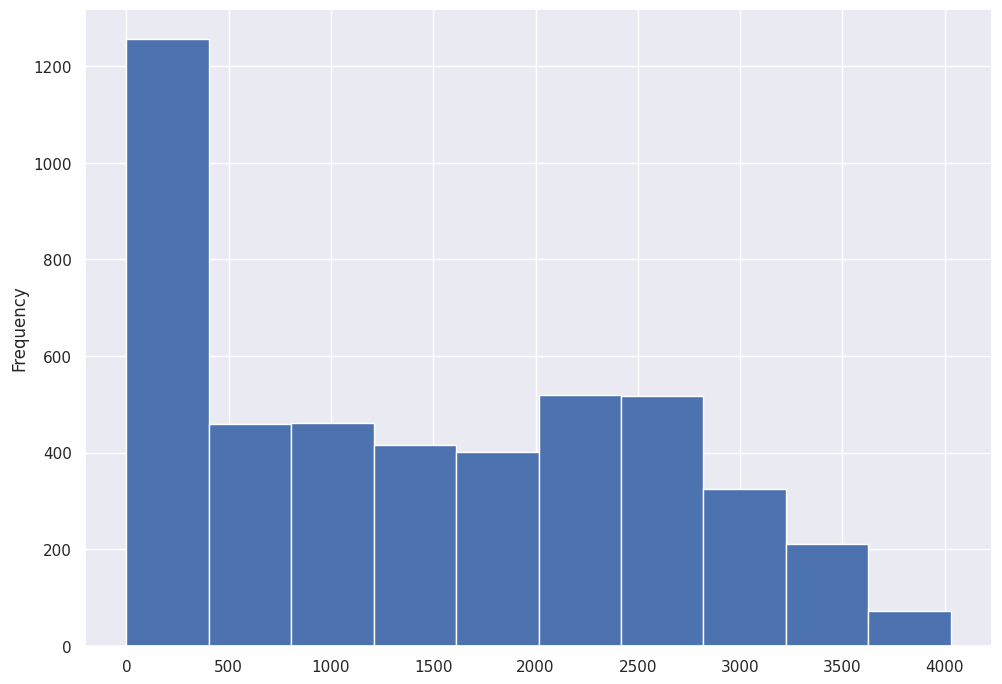

In [19]:
df["radiacao_global_kjm2"].plot.hist()

In [20]:
df[df["radiacao_global_kjm2"]>0]["radiacao_global_kjm2"].count()

4625

In [21]:
df[df["radiacao_global_kjm2"]>0]["radiacao_global_kjm2"].describe()

count    4625.000000
mean     1444.713189
std      1110.352696
min         0.100000
25%       339.400000
50%      1387.200000
75%      2390.000000
max      4030.000000
Name: radiacao_global_kjm2, dtype: float64

<Axes: ylabel='Frequency'>

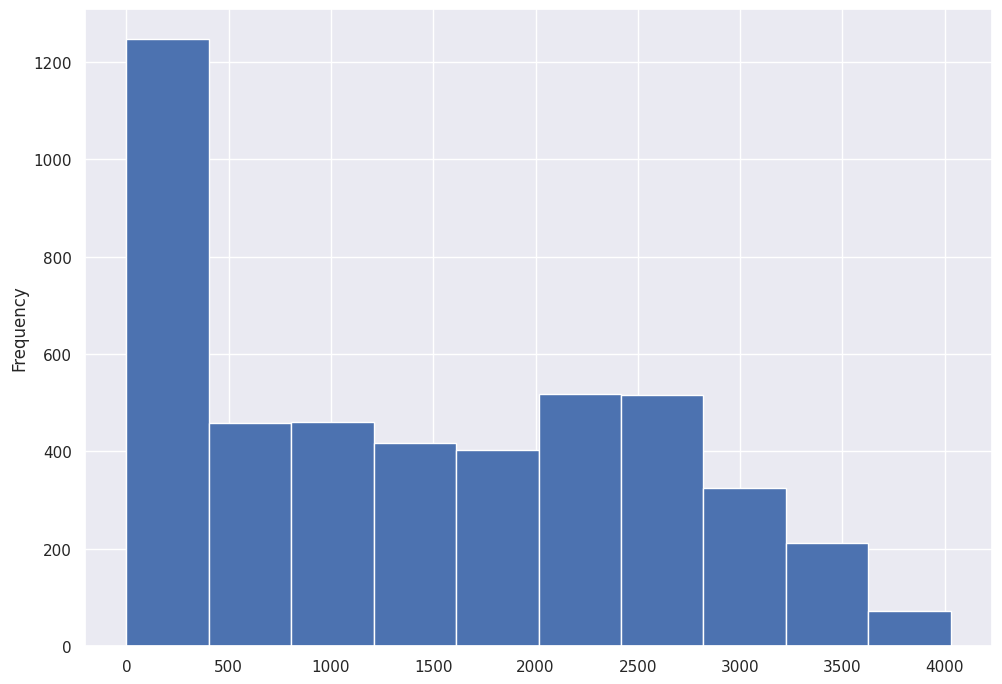

In [22]:
df[df["radiacao_global_kjm2"]>0]["radiacao_global_kjm2"].plot.hist()

Apesar do desbalanceamento dos dados, não se pode afirmar que a radiação tenha outliers. Portanto, não removeremos nenhum registro. Entretanto, podemos remover posteriormente apenas para ver o comportamento dos dados.

In [23]:
# df = df[df["radiacao_global_kjm2"]>0]

#### Vento
Aprentemente, a variável do vento contém alguns dados desbalanceados, como podemos ver aqui no histograma

<Axes: ylabel='Frequency'>

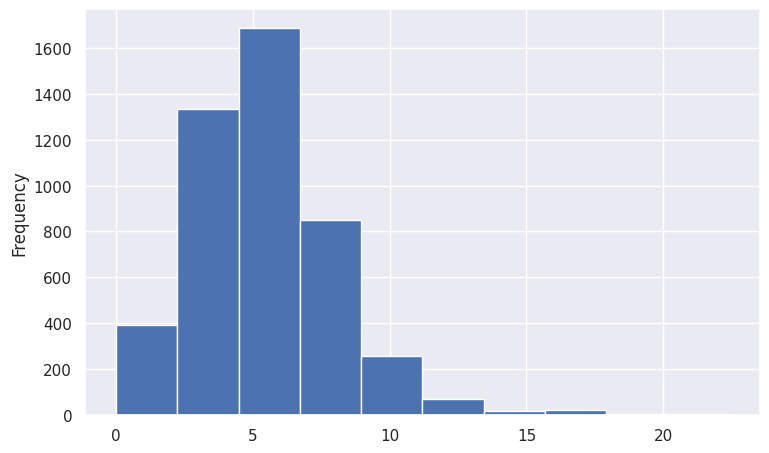

In [24]:
sns.set_theme(rc={'figure.figsize':(8.7,5.27)})
df["vento_rajada_maxima_ms"].plot.hist()

In [25]:
df[df["vento_rajada_maxima_ms"] > 15]["vento_rajada_maxima_ms"].count()

27

In [26]:
df = df[df["vento_rajada_maxima_ms"] <=15]

### Removendo colunas
A coluna `precipitacao_total_horario_mm` tem muitos zeros ou nulos, portanto, iremos remove-la.

In [27]:
df["precipitação_total_horário_mm"].value_counts()

precipitação_total_horário_mm
0.0     3806
0.2       73
0.4       24
0.6       20
0.8       13
        ... 
5.4        1
7.8        1
9.6        1
8.4        1
10.4       1
Name: count, Length: 61, dtype: int64

<Axes: ylabel='Frequency'>

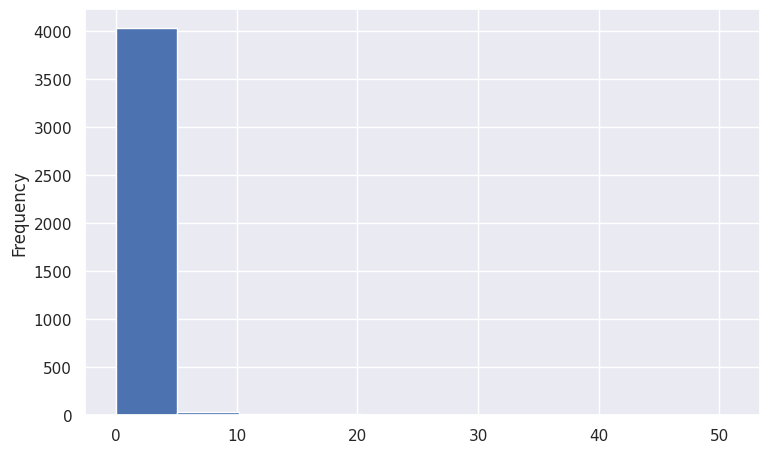

In [28]:
df["precipitação_total_horário_mm"].plot.hist()

In [29]:
without_relevance = ["temperatura_do_ponto_de_orvalho_c",
                 "temperatura_orvalho_max_na_hora_ant_aut_c",
                 "temperatura_orvalho_min_na_hora_ant_aut_c",
                 "vento_direção_horaria_gr__gr",
                 "vento_velocidade_horaria_ms"]

many_nulls_zeros = ["precipitação_total_horário_mm"]

without_relevance.extend(many_nulls_zeros)

df = df.drop(without_relevance, axis=1)

### Feature engineering
Algumas colunas possuem comportamento similar. Portanto, podemos mescla-las em uma só. 

#### Atmo Press

In [30]:
df.columns

Index(['pressao_atmosferica_ao_nivel_da_estacao_horaria_mb',
       'pressão_atmosferica_max_na_hora_ant_aut_mb',
       'pressão_atmosferica_min_na_hora_ant_aut_mb', 'radiacao_global_kjm2',
       'temperatura_do_ar_bulbo_seco_horaria_c',
       'temperatura_máxima_na_hora_ant_aut_c',
       'temperatura_mínima_na_hora_ant_aut_c',
       'umidade_rel_max_na_hora_ant_aut_perc',
       'umidade_rel_min_na_hora_ant_aut_perc',
       'umidade_relativa_do_ar_horaria_perc', 'vento_rajada_maxima_ms',
       'data_hora', 'hora', 'dia', 'mes', 'ano'],
      dtype='object')

In [31]:
join_press = [
            "pressao_atmosferica_ao_nivel_da_estacao_horaria_mb", 
            "pressão_atmosferica_max_na_hora_ant_aut_mb",
            "pressão_atmosferica_min_na_hora_ant_aut_mb"
       ]
df[join_press].describe().T

,count,mean,std,min,25%,50%,75%,max
pressao_atmosferica_ao_nivel_da_estacao_horaria_mb,4603.0,969.777667,3.780976,959.4,967.15,969.7,972.3,981.2
pressão_atmosferica_max_na_hora_ant_aut_mb,4603.0,970.142429,3.748487,959.8,967.50,970.0,972.6,981.2
pressão_atmosferica_min_na_hora_ant_aut_mb,4603.0,969.520704,3.785461,959.3,966.90,969.4,972.0,980.9


In [32]:
df_local =  df[join_press]
df["press_atmo"] = df_local.mean(axis=1)
df = df.drop(join_press, axis=1)

#### Temperature

In [33]:
mean_temp = [
        "temperatura_do_ar_bulbo_seco_horaria_c",
        "temperatura_máxima_na_hora_ant_aut_c",
        "temperatura_mínima_na_hora_ant_aut_c"]

df[mean_temp].describe().T

,count,mean,std,min,25%,50%,75%,max
temperatura_do_ar_bulbo_seco_horaria_c,4603.0,27.287856,5.372105,8.7,23.7,27.6,31.0,41.2
temperatura_máxima_na_hora_ant_aut_c,4603.0,28.011797,5.584367,8.7,24.2,28.5,31.9,41.5
temperatura_mínima_na_hora_ant_aut_c,4603.0,26.087964,5.544093,5.9,22.4,26.4,30.0,39.8


In [34]:
df_local =  df[mean_temp]
df["temperature"] = df_local.mean(axis=1)
df = df.drop(mean_temp, axis=1)

#### Humidity

In [35]:
mean_humidity = ["umidade_rel_max_na_hora_ant_aut_perc",
            "umidade_rel_min_na_hora_ant_aut_perc",
            "umidade_relativa_do_ar_horaria_perc"]

df[mean_humidity].describe().T

,count,mean,std,min,25%,50%,75%,max
umidade_rel_max_na_hora_ant_aut_perc,4603.0,62.794916,21.134389,15.0,46.0,63.0,81.0,97.0
umidade_rel_min_na_hora_ant_aut_perc,4603.0,54.678905,21.265398,12.0,37.0,52.0,71.0,97.0
umidade_relativa_do_ar_horaria_perc,4603.0,57.754508,20.934173,13.0,41.0,56.0,74.0,97.0


In [36]:
df_local =  df[mean_humidity]
df["humidity"] = df_local.mean(axis=1)
df = df.drop(mean_humidity, axis=1)

In [37]:
df.head()

,radiacao_global_kjm2,vento_rajada_maxima_ms,data_hora,hora,dia,mes,ano,press_atmo,temperature,humidity
9,5.1,3.7,2023-01-01 09:00:00,9,1,1,2023,969.033333,21.966667,93.000000
10,315.2,3.1,2023-01-01 10:00:00,10,1,1,2023,969.600000,23.133333,89.000000
11,1134.2,4.2,2023-01-01 11:00:00,11,1,1,2023,969.966667,25.333333,79.000000
12,1971.6,6.9,2023-01-01 12:00:00,12,1,1,2023,970.633333,27.366667,69.000000
13,2709.4,6.3,2023-01-01 13:00:00,13,1,1,2023,970.800000,29.066667,61.333333


### Analise com datas
Aqui iremos plotar a radiação por data

#### Ano

In [38]:
df_year = df[["ano", "radiacao_global_kjm2"]].groupby(['ano']).mean().reset_index()

#### Média e desvio
Apenas para garantir que não temos uma discrepância entre média e desvio, vamos exibir por ano. 

In [39]:
df[["ano", "radiacao_global_kjm2"]].groupby(['ano'])\
['radiacao_global_kjm2'].agg(['mean','std'])

,mean,std
ano,,
2023,1448.460569,1110.633574


In [40]:
df_test = df[["ano", "radiacao_global_kjm2"]].groupby(['ano'])\
['radiacao_global_kjm2'].agg(['mean','std']).reset_index()

df_test[df_test["ano"] >= 2020].agg(['mean','std'])

,ano,mean,std
mean,2023.0,1448.460569,1110.633574
std,NaN,NaN,NaN


<Axes: xlabel='ano', ylabel='radiacao_global_kjm2'>

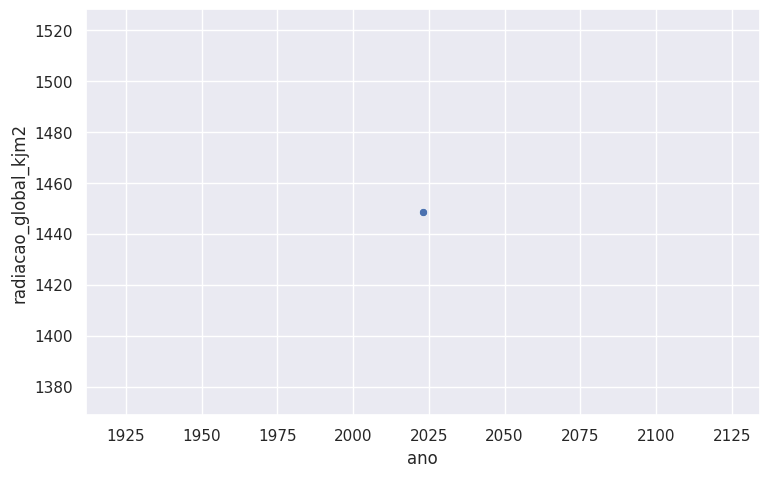

In [41]:
sns.scatterplot(data=df_year, x=df_year["ano"], y=df_year["radiacao_global_kjm2"])

#### Mes

In [42]:
df_month = df[["mes", "radiacao_global_kjm2"]].groupby(['mes']).mean().reset_index()

<Axes: xlabel='mes', ylabel='radiacao_global_kjm2'>

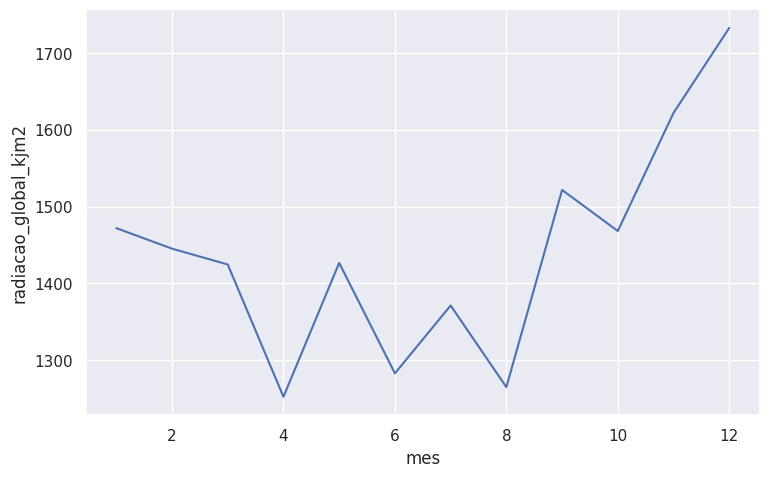

In [43]:
sns.lineplot(data=df_month, x=df_month["mes"], y=df_month["radiacao_global_kjm2"])

#### Hora

In [44]:
df_hour = df[["hora", "radiacao_global_kjm2"]].groupby(['hora']).mean().reset_index()

<Axes: xlabel='hora', ylabel='radiacao_global_kjm2'>

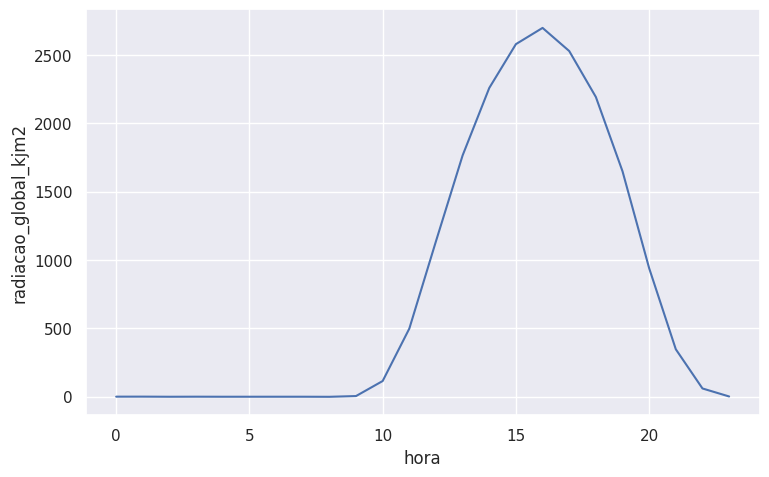

In [45]:
sns.lineplot(data=df_hour, x=df_hour["hora"], y=df_hour["radiacao_global_kjm2"])

#### Hora com o vento como `hue`

In [46]:
df_hour_wind = df[[
    "hora", 
    "radiacao_global_kjm2", 
    "vento_rajada_maxima_ms"]]\
.fillna(0)

df_hour_wind["wind_catg"] = create_category("vento_rajada_maxima_ms", df_hour_wind)


<Axes: xlabel='hora', ylabel='radiacao_global_kjm2'>

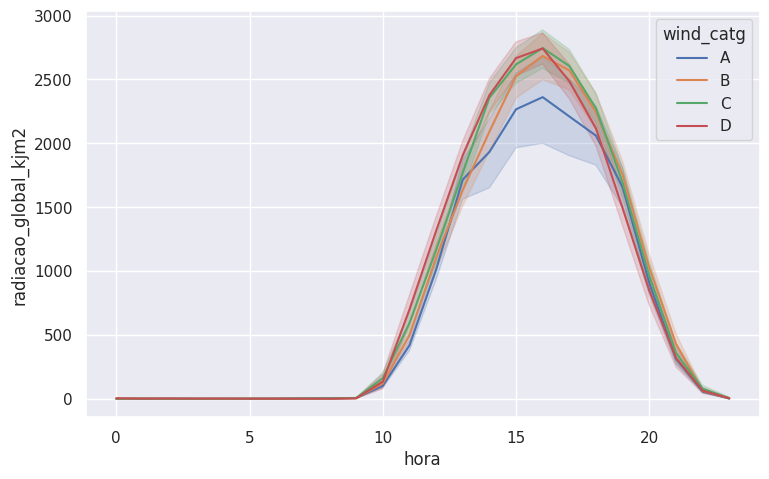

In [47]:
sns.lineplot(data=df_hour_wind, x=df_hour_wind["hora"], y=df_hour_wind["radiacao_global_kjm2"], hue=df_hour_wind["wind_catg"])

#### Hora com a pressão atmo. como `hue`

In [48]:
df_hour_press = df[[
    "hora", 
    "radiacao_global_kjm2", 
    "press_atmo"]]\
.fillna(0)

df_hour_press["press_catg"] = create_category("press_atmo", df_hour_press)

<Axes: xlabel='hora', ylabel='radiacao_global_kjm2'>

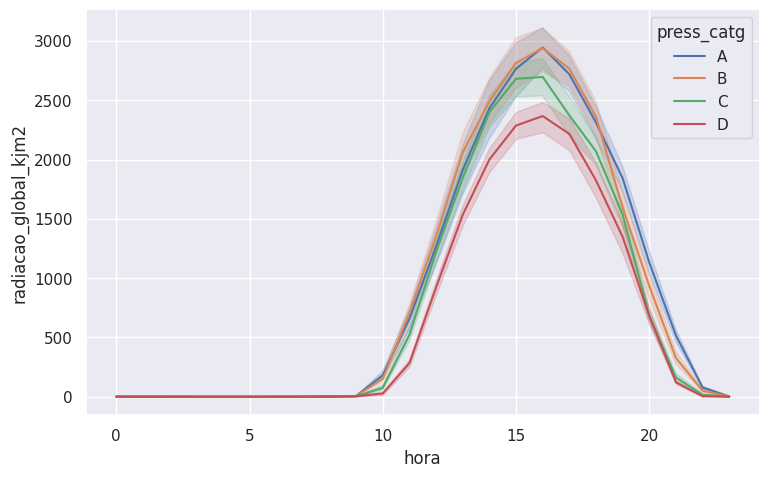

In [49]:
sns.lineplot(data=df_hour_press, x=df_hour_press["hora"], y=df_hour_press["radiacao_global_kjm2"], hue=df_hour_press["press_catg"])

#### Hora com a temperatura como `hue`

In [50]:
df_temp = df[[
    "hora", 
    "radiacao_global_kjm2", 
    "temperature"]]\
.fillna(0)

df_temp["temp_catg"] = create_category("temperature", df_temp)

<Axes: xlabel='hora', ylabel='radiacao_global_kjm2'>

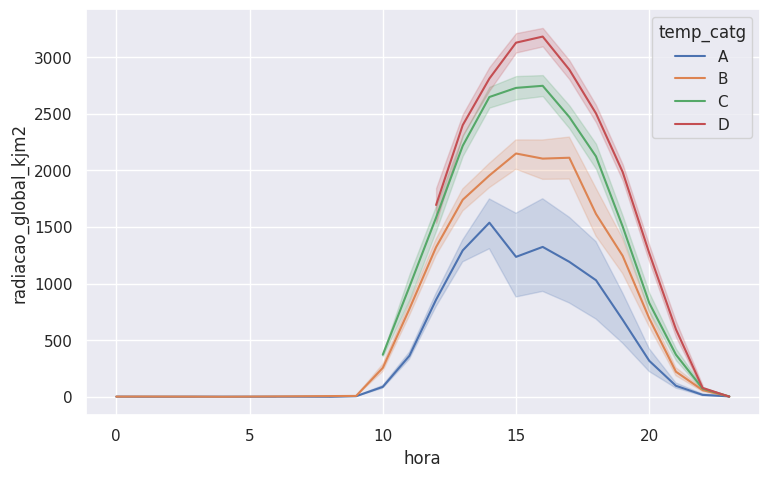

In [51]:
sns.lineplot(data=df_temp, x=df_temp["hora"], y=df_temp["radiacao_global_kjm2"], hue=df_temp["temp_catg"])

#### Hora com a umidade como `hue`

In [52]:
df_temp = df[[
    "hora", 
    "radiacao_global_kjm2", 
    "humidity"]]\
.fillna(0)

df_temp["hum_catg"] = create_category("humidity", df_temp)

<Axes: xlabel='hora', ylabel='radiacao_global_kjm2'>

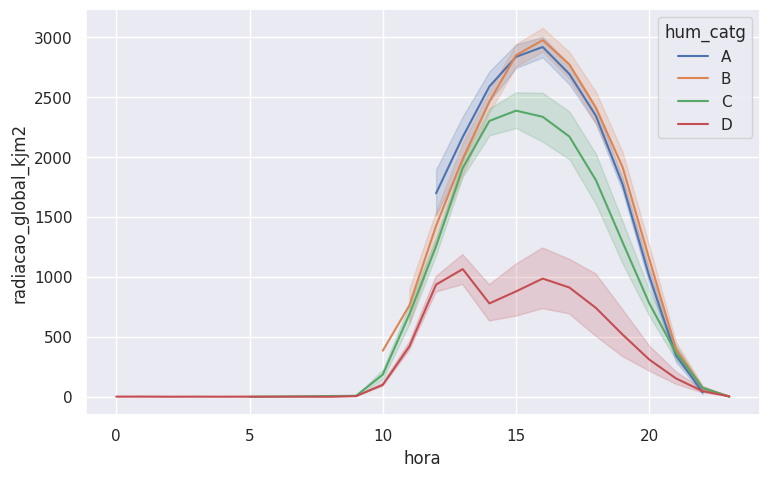

In [53]:
sns.lineplot(data=df_temp, x=df_temp["hora"], y=df_temp["radiacao_global_kjm2"], hue=df_temp["hum_catg"])

#### Relação linear entre radiação e vento 

<Axes: xlabel='vento_rajada_maxima_ms', ylabel='radiacao_global_kjm2'>

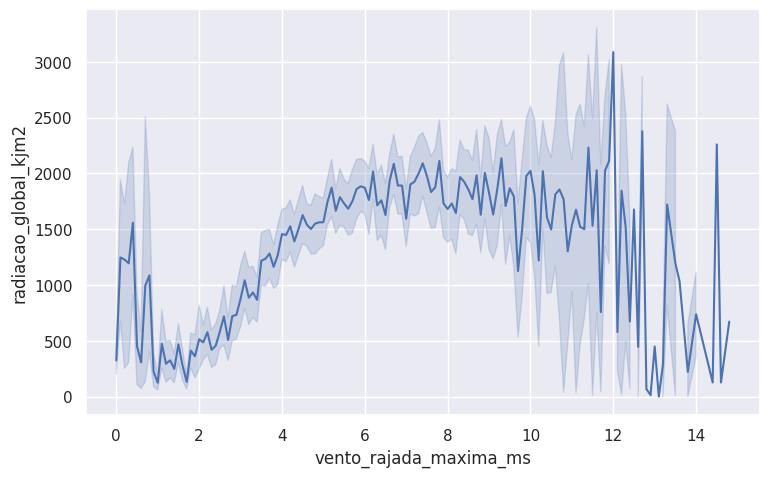

In [54]:
sns.lineplot(data=df, x=df["vento_rajada_maxima_ms"], y=df["radiacao_global_kjm2"])

### Conclusões

#### Desbalanceamento
O dataset possui uma quantidade razoável de nulos, quando falamos da coluna "alvo" radiação, que fica em torno de \~17%. Como não chega a ser um valor expressivo, podemos simplesmente remover os nulos dessa coluna. Em seguida, analisamos as estatisticas dos dados, como média, desvio padrão e quartis. O que foi percebido é um valor alto do desvio em relação a média, podendo indicar a presença de outliers. Entretanto, o dataset na verdade possui dados desbalanceados, tendo muitos valores negativos (~42%) na mesma faixa de valores, o que pode comppromenter uma futura previsão. Aqui podemos tratar esse desbalanceamento com algumas técnicas, como o undersampling, por exemplo. Iremos remover posteriormente, apenas para checar o comportamento dos dados quando plotamos.

Ainda falando de dados desbalanceados, temos também a categoria "vento", que contém um numero pequeno de registros acima do valor 15. Portanto, para fins de previsão, podemos remove-los.

Sobre a coluna de precipitação, temos valores zerados ou nulos quase em sua totalidade. Portanto, iremos remove-la do dataset.

#### Feature Engineering

No dataset, existem colunas que representam o mesmo conceito, e possuem medidas estatisticas (media, desvio) semelhantes. Portanto, aplicamos alguns métodos para "juntarmos" essas colunas semelhantes em uma só, como o caso das colunas de pressão atmosférica, umidade e temperatura.


#### Analise com datas

Para termos ma visão geral falando de séries temporais, agregamos os dados por ano, mes e horário, para tentar enxergar algum padrão.

##### Por ano
Agregando os dados por ano, notou-se um comportamento incomun entre ~2008-2020, onde temos niveis baixos de radiação média ( ~935) em relação ao niveis médios a partir de 2020 ( ~1871). Não foi encontrado um motivo particular para esse comportamento.

##### Por mes
Construindo um gráfico com dados agregados por mes, não houve nenhum ponto atípico. Os dados mostram uma maior incidência de radiação no início do ano (verão), com uma queda acentuada assim que deslocamos a coluna temporal até o meio do ano (outuno-inverno), com novo aumento da radiação assim que se aproxima do final do ano (primavera-verão).

##### Por hora
Assim como o plot por mês, não houve nenhum comportamento atípico ao esperado, tendo a faixa ~10h-17h a maior incidência de radição do dia, caindo bruscamente a partir das 20h.

##### Valores horários por outra colunas
Nessa análise, decidimos isolar as observações horárias por categorias (A, B, C e D) dentro de algumas colunas. Ou seja, utilizamos os quartis dessas colunas e categorizamos os valores. Ex: temperatura categoria A: de 0 a 15, categoria B: de 15 a 25, e assim por diante. As seguintes colunas foram utilzadas:

- **Vento**: Percebemos uma ligeira relação diretamente proporcional entre ventos fortes e maiores niveis de radiação, porém nada relevante.
- **Pressão atmosférica**: aqui tivemos um aumento dessa relação entre uma categoria esecifica (baixa pressão atmosférica) e o nivel de radiação solar.
- **Temperatura**: no caso da temperatura, não houve comportamento ineserado, prevaelecendo as altas temperaturas com incidência da radiação.
- **Umidade**: da mesma forma que a temperatura, também não houve nada diferente do previsto, com as baixas taxas de umidade tendo relação forte com altos valores de radiação solar.

##### Relação linear
Como ultima análise, decidimos verificar se existe uma relação linear entre alguma coluna e os valores de radiação. Como escolha, tivemos um resultado interessante utilzando o vento novamente. O gráfico mostra que o pico de radiação é atingido quando a rajada máxima de vento fica entre 8-10 m/s, com queda acentuada ao ultrapassar esses valores. 
